# Getting Started

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk
# nltk.download('averaged_perceptron_tagger')
# nltk.download('vader_lexicon')
# nltk.download('maxent_ne_chunker')
# nltk.download('words')

In [2]:
# Read in data
df = pd.read_csv(r"C:\Users\chaya\OneDrive\Documents\Datasets\AmazonReviews.csv")
print(df.shape)

(4915, 3)


In [3]:
df.head()

,Id,Score,Text
0,0,4,No issues.
1,1,5,"Purchased this for my device, it worked as adv..."
2,2,4,it works as expected. I should have sprung for...
3,3,5,This think has worked out great.Had a diff. br...
4,4,5,"Bought it with Retail Packaging, arrived legit..."


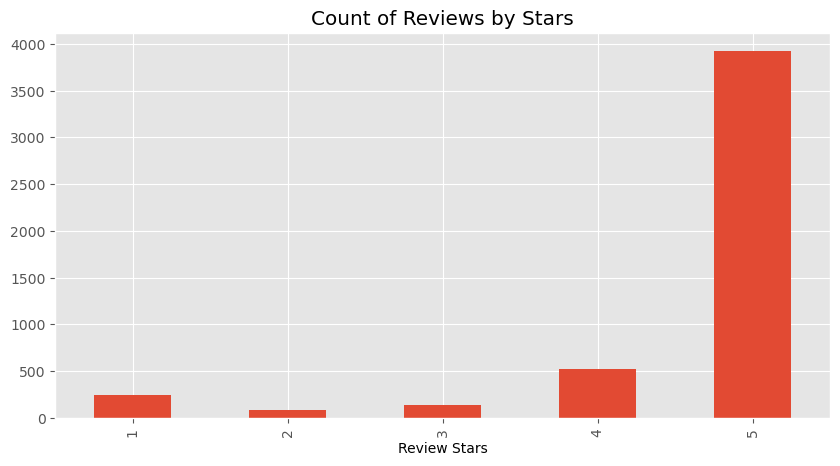

In [4]:
ax = df['Score'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show()

In [5]:
# get sample text
example = df['Text'].sample(random_state=42).iloc[0]
print(example)

When I opened the micro disc and adapter I did't know what to do with them. I went to UTube on installing them, and all became clear. The micro fits into the top of the adapter and then the whole thing fits into my camera. Very neat and high powered.


In [6]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['When', 'I', 'opened', 'the', 'micro', 'disc', 'and', 'adapter', 'I', "did't"]

In [7]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('When', 'WRB'),
 ('I', 'PRP'),
 ('opened', 'VBD'),
 ('the', 'DT'),
 ('micro', 'NN'),
 ('disc', 'NN'),
 ('and', 'CC'),
 ('adapter', 'NN'),
 ('I', 'PRP'),
 ("did't", 'VBP')]

In [8]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  When/WRB
  I/PRP
  opened/VBD
  the/DT
  micro/NN
  disc/NN
  and/CC
  adapter/NN
  I/PRP
  did't/VBP
  know/VB
  what/WP
  to/TO
  do/VB
  with/IN
  them/PRP
  ./.
  I/PRP
  went/VBD
  to/TO
  (ORGANIZATION UTube/NNP)
  on/IN
  installing/VBG
  them/PRP
  ,/,
  and/CC
  all/DT
  became/VBD
  clear/JJ
  ./.
  The/DT
  micro/NN
  fits/VBZ
  into/IN
  the/DT
  top/NN
  of/IN
  the/DT
  adapter/NN
  and/CC
  then/RB
  the/DT
  whole/JJ
  thing/NN
  fits/VBZ
  into/IN
  my/PRP$
  camera/NN
  ./.
  Very/RB
  neat/JJ
  and/CC
  high/JJ
  powered/VBN
  ./.)


# VADER Sentiment Scoring

In [9]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [10]:
sia.polarity_scores('I am so happy!')

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [11]:
sia.polarity_scores('This is the worst thing ever.')

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

In [12]:
sia.polarity_scores(example)

{'neg': 0.0, 'neu': 0.851, 'pos': 0.149, 'compound': 0.7713}

In [13]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Text']
    myid = row['Id']
    res[myid] = sia.polarity_scores(str(text))

  0%|          | 0/4915 [00:00<?, ?it/s]

In [14]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
vaders = vaders.merge(df, how='left')

In [15]:
# Now we have sentiment score and metadata
vaders.head()

,Id,neg,neu,pos,compound,Score,Text
0,0,0.688,0.312,0.000,-0.2960,4,No issues.
1,1,0.075,0.925,0.000,-0.2960,5,"Purchased this for my device, it worked as adv..."
2,2,0.077,0.923,0.000,-0.3089,4,it works as expected. I should have sprung for...
3,3,0.000,0.909,0.091,0.7081,5,This think has worked out great.Had a diff. br...
4,4,0.038,0.835,0.127,0.7087,5,"Bought it with Retail Packaging, arrived legit..."


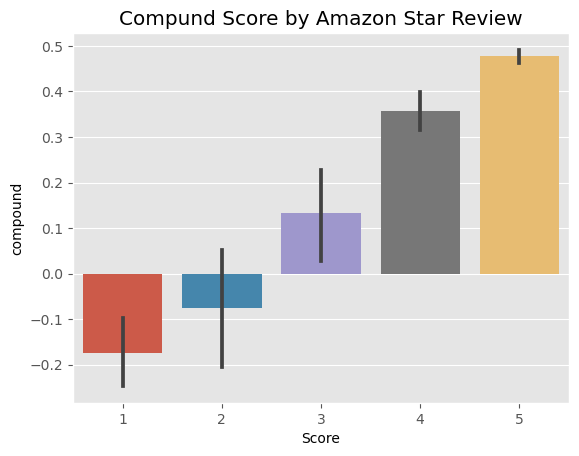

In [16]:
ax = sns.barplot(data=vaders, x='Score', y='compound')
ax.set_title('Compund Score by Amazon Star Review')
plt.show()

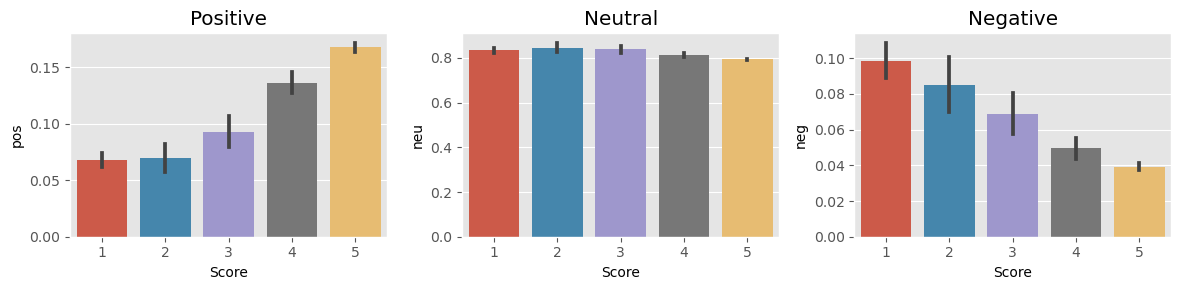

In [17]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='Score', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='Score', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='Score', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

# ROBERTA Pretrained Model

In [18]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [19]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [20]:
# VADER results on example
print(example)
sia.polarity_scores(example)

When I opened the micro disc and adapter I did't know what to do with them. I went to UTube on installing them, and all became clear. The micro fits into the top of the adapter and then the whole thing fits into my camera. Very neat and high powered.


{'neg': 0.0, 'neu': 0.851, 'pos': 0.149, 'compound': 0.7713}

In [21]:
# Run for Roberta Model
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.0051811547, 'roberta_neu': 0.06119816, 'roberta_pos': 0.9336207}


In [22]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [23]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = str(row['Text'])
        myid = row['Id']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/4915 [00:00<?, ?it/s]

Broke for id 76
Broke for id 123
Broke for id 722
Broke for id 1380
Broke for id 2031
Broke for id 2799
Broke for id 2881
Broke for id 2934
Broke for id 2993
Broke for id 3345
Broke for id 3449
Broke for id 3757
Broke for id 3967
Broke for id 4176
Broke for id 4212
Broke for id 4423
Broke for id 4587
Broke for id 4596


In [24]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})
results_df = results_df.merge(df, how='left')

In [25]:
results_df.columns

Index(['Id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'Score', 'Text'],
      dtype='object')

In [26]:
results_df.head()

,Id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,Score,Text
0,0,0.688,0.312,0.000,-0.2960,0.074959,0.589215,0.335826,4,No issues.
1,1,0.075,0.925,0.000,-0.2960,0.007265,0.095529,0.897206,5,"Purchased this for my device, it worked as adv..."
2,2,0.077,0.923,0.000,-0.3089,0.423757,0.448311,0.127933,4,it works as expected. I should have sprung for...
3,3,0.000,0.909,0.091,0.7081,0.002447,0.019229,0.978324,5,This think has worked out great.Had a diff. br...
4,4,0.038,0.835,0.127,0.7087,0.003552,0.067459,0.928989,5,"Bought it with Retail Packaging, arrived legit..."


## Visualizing the Results

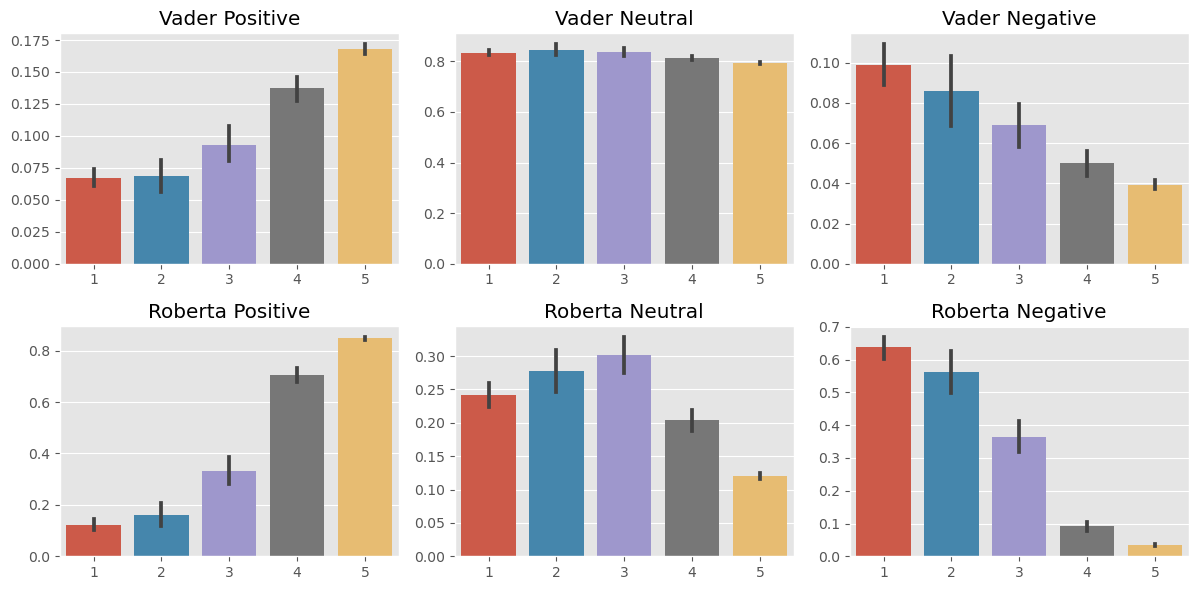

In [27]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6))
sns.barplot(data=results_df, x='Score', y='vader_pos', ax=axs[0][0])
sns.barplot(data=results_df, x='Score', y='vader_neu', ax=axs[0][1])
sns.barplot(data=results_df, x='Score', y='vader_neg', ax=axs[0][2])
sns.barplot(data=results_df, x='Score', y='roberta_pos', ax=axs[1][0])
sns.barplot(data=results_df, x='Score', y='roberta_neu', ax=axs[1][1])
sns.barplot(data=results_df, x='Score', y='roberta_neg', ax=axs[1][2])
axs[0][0].set_title('Vader Positive')
axs[0][1].set_title('Vader Neutral')
axs[0][2].set_title('Vader Negative')
axs[1][0].set_title('Roberta Positive')
axs[1][1].set_title('Roberta Neutral')
axs[1][2].set_title('Roberta Negative')
for ax in axs.flat:
    ax.set_xlabel('')
    ax.set_ylabel('')
plt.tight_layout()
plt.show()


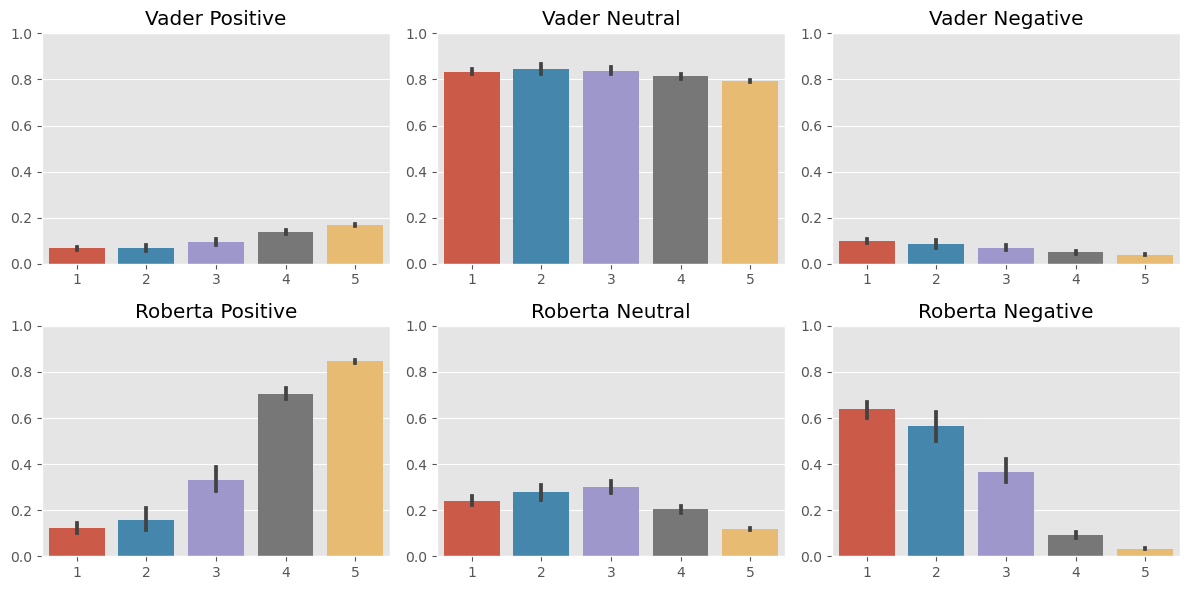

In [28]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6))
sns.barplot(data=results_df, x='Score', y='vader_pos', ax=axs[0][0])
sns.barplot(data=results_df, x='Score', y='vader_neu', ax=axs[0][1])
sns.barplot(data=results_df, x='Score', y='vader_neg', ax=axs[0][2])
sns.barplot(data=results_df, x='Score', y='roberta_pos', ax=axs[1][0])
sns.barplot(data=results_df, x='Score', y='roberta_neu', ax=axs[1][1])
sns.barplot(data=results_df, x='Score', y='roberta_neg', ax=axs[1][2])
axs[0][0].set_title('Vader Positive')
axs[0][1].set_title('Vader Neutral')
axs[0][2].set_title('Vader Negative')
axs[1][0].set_title('Roberta Positive')
axs[1][1].set_title('Roberta Neutral')
axs[1][2].set_title('Roberta Negative')
for ax in axs.flat:
    ax.set_ylim([0, 1])
    ax.set_xlabel('')
    ax.set_ylabel('')
plt.tight_layout()
plt.show()

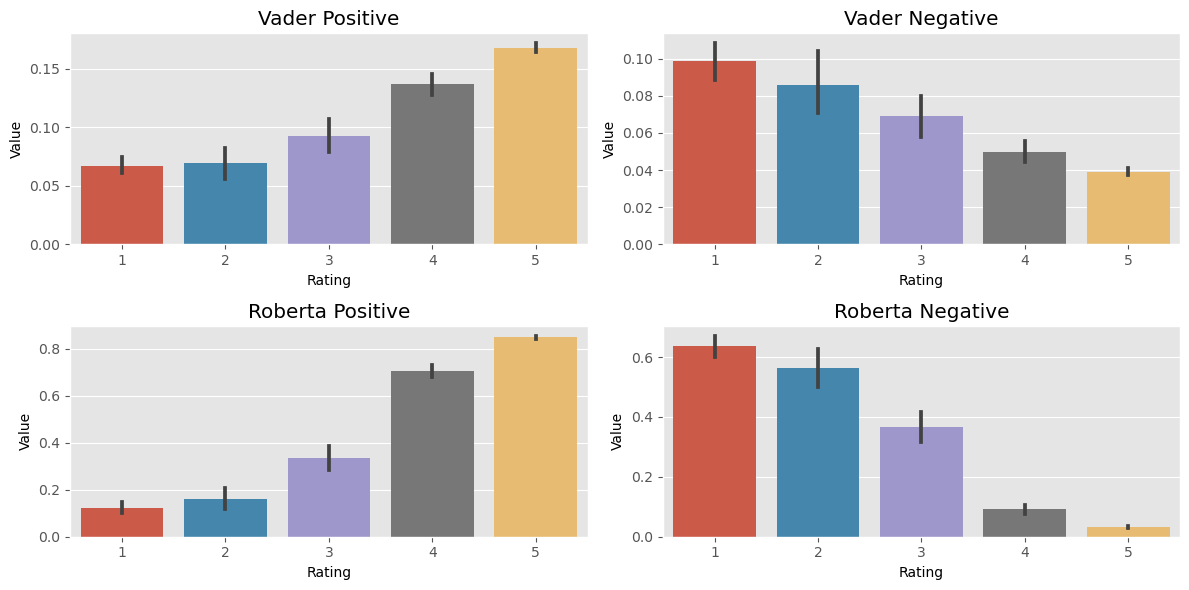

In [29]:
import matplotlib.ticker as ticker

fig, axs = plt.subplots(2, 2, figsize=(12, 6))
sns.barplot(data=results_df, x='Score', y=(results_df['vader_pos']), ax=axs[0][0])
sns.barplot(data=results_df, x='Score', y=(results_df['vader_neg']), ax=axs[0][1])
sns.barplot(data=results_df, x='Score', y=(results_df['roberta_pos']), ax=axs[1][0])
sns.barplot(data=results_df, x='Score', y=(results_df['roberta_neg']), ax=axs[1][1])
axs[0][0].set_title('Vader Positive')
axs[0][1].set_title('Vader Negative')
axs[1][0].set_title('Roberta Positive')
axs[1][1].set_title('Roberta Negative')
for ax in axs.flat:
    ax.set_xlabel('Rating')
    ax.set_ylabel('Value')
    #ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True)) # Format y-axis ticks as integers

plt.tight_layout()
plt.show()

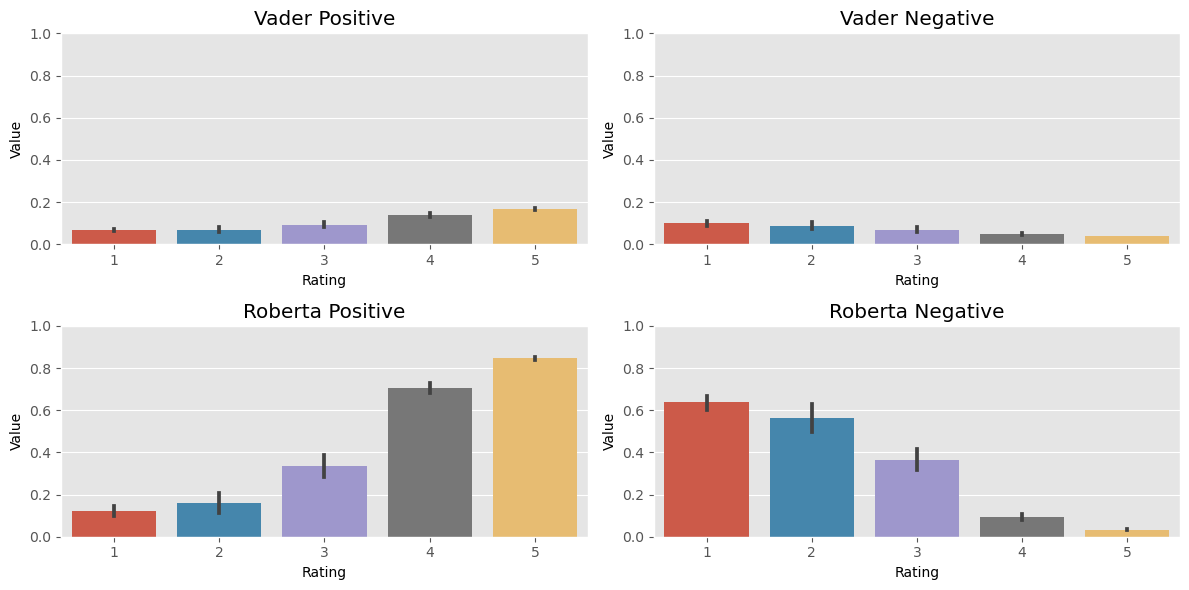

In [30]:
import matplotlib.ticker as ticker

fig, axs = plt.subplots(2, 2, figsize=(12, 6))
sns.barplot(data=results_df, x='Score', y=(results_df['vader_pos']), ax=axs[0][0])
sns.barplot(data=results_df, x='Score', y=(results_df['vader_neg']), ax=axs[0][1])
sns.barplot(data=results_df, x='Score', y=(results_df['roberta_pos']), ax=axs[1][0])
sns.barplot(data=results_df, x='Score', y=(results_df['roberta_neg']), ax=axs[1][1])
axs[0][0].set_title('Vader Positive')
axs[0][1].set_title('Vader Negative')
axs[1][0].set_title('Roberta Positive')
axs[1][1].set_title('Roberta Negative')
for ax in axs.flat:
    ax.set_ylim([0, 1])
    ax.set_xlabel('Rating')
    ax.set_ylabel('Value')
    #ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True)) # Format y-axis ticks as integers

plt.tight_layout()
plt.show()

# Compare Scores

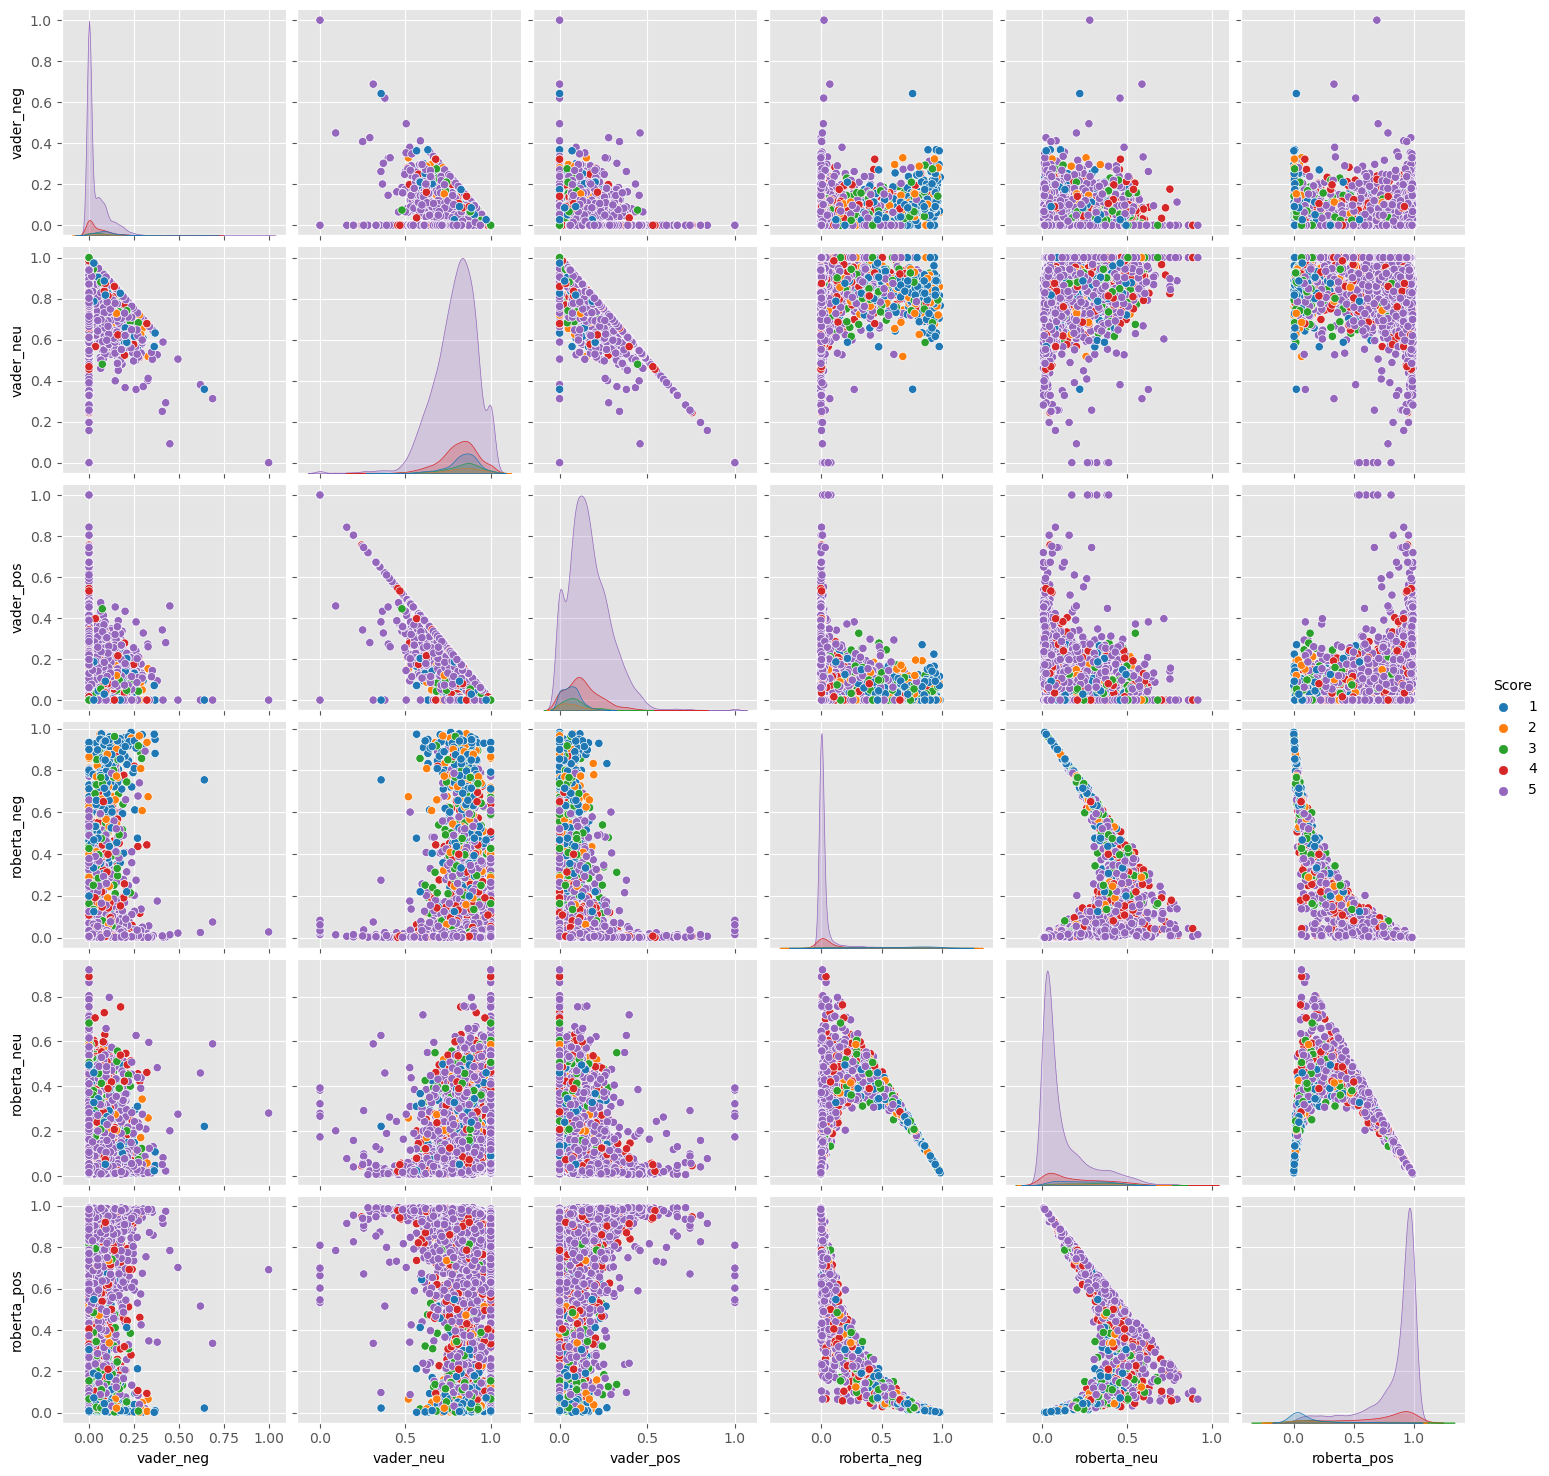

In [31]:
sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='Score',
            palette='tab10')
plt.show()

In [32]:
# positive sentiment 1-Star view Roberta

results_df.query('Score == 1') \
    .sort_values('roberta_pos', ascending=False)['Text'].values[0]

'I returned to order a 11.6 laptop so I could have full operations than having a Notebook. I am sure this is good quality as I have purchased San Disk numerous times.'

In [33]:
# positive sentiment 1-Star view Roberta

results_df.query('Score == 1') \
    .sort_values('vader_pos', ascending=False)['Text'].values[0]

'Crashed... Lost everything... Thanks SanDisk.  Used in gs4..not a solid product couple years worth of stuff gone in an instant.'

In [34]:
# nevative sentiment 5-Star view Roberta

results_df.query('Score == 5') \
    .sort_values('roberta_neg', ascending=False)['Text'].values[0]

"I only buy thru Amazon I've tried eBay and you always come thru and I got messed over four times and no real recourse you just lose and PayPal is nobodies pal. And these no more rack are terrible and all these others take my advise stick with the one that has always came thru every time for me. Amazon and only Amazon . H.Rhodes"

In [35]:
# nevative sentiment 5-Star view Vader
results_df.query('Score == 5') \
    .sort_values('vader_neg', ascending=False)['Text'].values[0]

'No problems!'

# Predict Score

In [36]:
# vader prediction

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Load data
data = results_df

# Prepare data
X = data[['vader_neg', 'vader_neu', 'vader_pos', 'vader_compound']].values
y = data['Score'].values

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)

# Create and fit the model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on test data
y_pred_v = model.predict(X_test)

# Round predicted values to nearest integer
y_pred_v_rounded = np.round(y_pred_v)

# Evaluate model performance using root mean squared error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_v))
print('Root mean squared error: ', rmse)

# Calculate accuracy score for the predictions
accuracy = model.score(X_test, y_test)
print('Accuracy score: ', accuracy)


Root mean squared error:  0.9968172842423195
Accuracy score:  0.1269177433926829


In [37]:
# roberta prediction

# Prepare data
X = data[['roberta_neg', 'roberta_neu', 'roberta_pos']].values
y = data['Score'].values

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)

# Create and fit the model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on test data
y_pred_r = model.predict(X_test)

# Round predicted values to nearest integer
y_pred_r_rounded = np.round(y_pred_r)

# Evaluate model performance using root mean squared error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_r))
print('Root mean squared error: ', rmse)

# Calculate accuracy score for the predictions
accuracy = model.score(X_test, y_test)
print('Accuracy score: ', accuracy)


Root mean squared error:  0.7137812053183863
Accuracy score:  0.5523338473708039


In [38]:
# add columns to new df

new_df = pd.DataFrame(y_test)
new_df['Score'] = y_test
new_df['vader_pred'] = y_pred_v_rounded
new_df['roberta_pred'] = y_pred_r_rounded
new_df = new_df[['Score', 'vader_pred', 'roberta_pred']]

new_df.head(10)

,Score,vader_pred,roberta_pred
0,5,5.0,5.0
1,1,4.0,2.0
2,5,4.0,5.0
3,5,5.0,5.0
4,5,4.0,5.0
5,1,4.0,3.0
6,5,5.0,4.0
7,5,5.0,5.0
8,5,5.0,5.0
9,5,5.0,5.0
